In [1]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#upload MNIST
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/data/MNIST/MNIST/processed/training.pt'
#file_path = "C:\Users\dipiy\Downloads\MNIST\MNIST\processed\training.pt"
x, y = torch.load(file_path)

Mounted at /content/drive


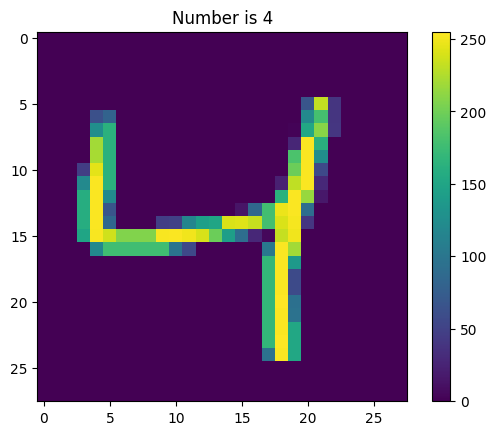

In [3]:
#example image
plt.imshow(x[2].numpy())
plt.title(f'Number is {y[2].numpy()}')
plt.colorbar()
plt.show()

In [4]:
#one hot encoder
y_original = torch.tensor([2, 4, 3, 0, 1])
y_new = F.one_hot(y_original)

In [5]:
y_original

tensor([2, 4, 3, 0, 1])

In [6]:
y_new

tensor([[0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0]])

In [7]:
class CTDataset(Dataset):
    def __init__(self, filepath):
        self.x, self.y = torch.load(filepath)
        self.x = self.x / 255.
        self.y = F.one_hot(self.y, num_classes=10).to(float)
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

In [10]:
train_ds = CTDataset('/content/drive/My Drive/data/MNIST/MNIST/processed/training.pt')
test_ds = CTDataset('/content/drive/My Drive/data/MNIST/MNIST/processed/test.pt')


In [11]:
#slicing
xs, ys = train_ds[0:4]

In [12]:
#pytorch dataloader object
train_dl = DataLoader(train_ds, batch_size=5)

In [13]:
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([5, 28, 28])
torch.Size([5, 10])


In [14]:
len(train_dl)

12000

In [15]:
L = nn.CrossEntropyLoss()

#Neural Net

In [16]:
class MyNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(28**2,100)
        self.Matrix2 = nn.Linear(100,50)
        self.Matrix3 = nn.Linear(50,10)
        self.R = nn.ReLU()
    def forward(self,x):
        x = x.view(-1,28**2)
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.Matrix3(x)
        return x.squeeze()

In [17]:
f = MyNeuralNet()

In [18]:
xs.shape

torch.Size([4, 28, 28])

In [19]:
f(xs)

tensor([[ 0.0070, -0.1656,  0.1731,  0.0743, -0.0774, -0.0706,  0.0267, -0.0881,
         -0.1086,  0.0313],
        [ 0.0142, -0.1188,  0.1433,  0.0305, -0.1013, -0.0537,  0.0302, -0.0597,
         -0.0923, -0.0083],
        [ 0.0310, -0.1350,  0.1801,  0.0678, -0.0893, -0.0113, -0.0015, -0.1025,
         -0.1252, -0.0179],
        [ 0.0367, -0.1176,  0.1713,  0.0611, -0.1160, -0.0423,  0.0189, -0.0691,
         -0.1008, -0.0440]], grad_fn=<SqueezeBackward0>)

In [20]:
L(f(xs), ys)

tensor(2.3519, dtype=torch.float64, grad_fn=<DivBackward1>)

#Training

In [21]:
def train_model(dl, f, n_epochs=20):
    # Optimization
    opt = SGD(f.parameters(), lr=0.01)
    L = nn.CrossEntropyLoss()

    # Train model
    losses = []
    epochs = []
    for epoch in range(n_epochs):
        print(f'Epoch {epoch}')
        N = len(dl)
        for i, (x, y) in enumerate(dl):
            # Update the weights of the network
            opt.zero_grad()
            loss_value = L(f(x), y)
            loss_value.backward()
            opt.step()
            # Store training data
            epochs.append(epoch+i/N)
            losses.append(loss_value.item())
    return np.array(epochs), np.array(losses)

In [22]:
epoch_data, loss_data = train_model(train_dl, f)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


Text(0.5, 1.0, 'Cross Entropy (per batch)')

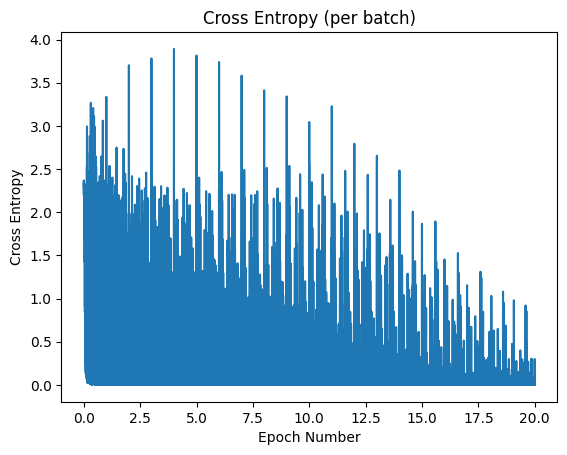

In [23]:
plt.plot(epoch_data, loss_data)
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy (per batch)')

In [24]:
epoch_data_avgd = epoch_data.reshape(20,-1).mean(axis=1)
loss_data_avgd = loss_data.reshape(20,-1).mean(axis=1)

Text(0.5, 1.0, 'Cross Entropy (avgd per epoch)')

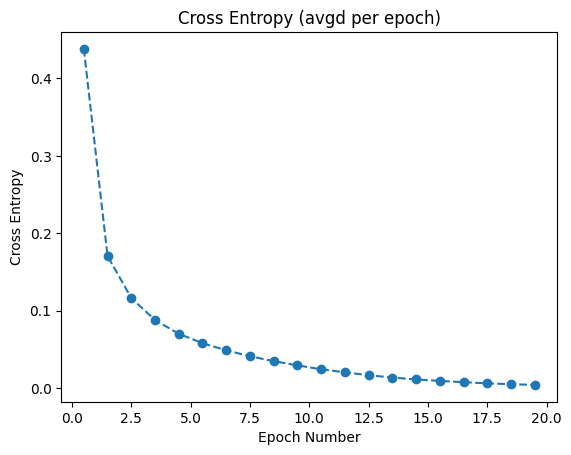

In [25]:
plt.plot(epoch_data_avgd, loss_data_avgd, 'o--')
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy (avgd per epoch)')

In [26]:
y_sample = train_ds[0][1]
y_sample

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=torch.float64)

In [27]:
x_sample = train_ds[0][0]
yhat_sample = f(x_sample)
yhat_sample

tensor([-10.9887,   1.3959,   5.2184,  26.6780, -27.8137,  29.3122, -14.2448,
          0.9859,  -3.6958,  -2.4510], grad_fn=<SqueezeBackward0>)

In [28]:
torch.argmax(yhat_sample)

tensor(5)

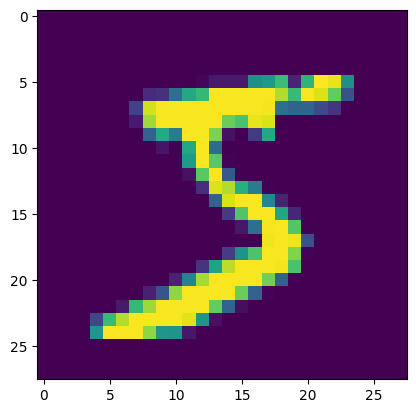

In [29]:
plt.imshow(x_sample)

In [30]:
xs, ys = train_ds[0:2000]
yhats = f(xs).argmax(axis=1)

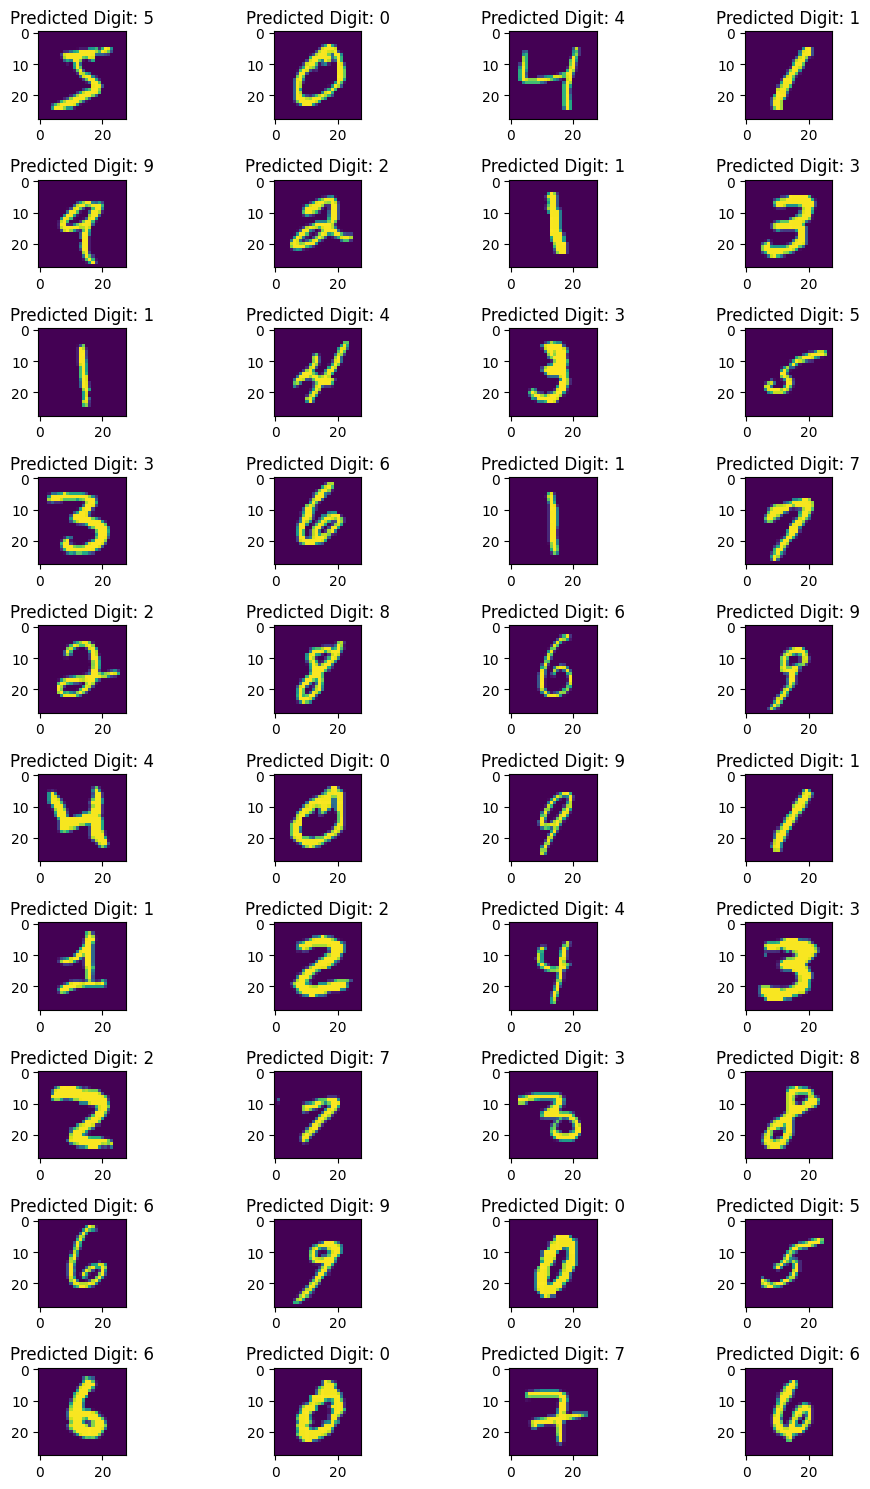

In [31]:
fig, ax = plt.subplots(10,4,figsize=(10,15))
for i in range(40):
    plt.subplot(10,4,i+1)
    plt.imshow(xs[i])
    plt.title(f'Predicted Digit: {yhats[i]}')
fig.tight_layout()
plt.show()

In [32]:
xs, ys = test_ds[:2000]
yhats = f(xs).argmax(axis=1)

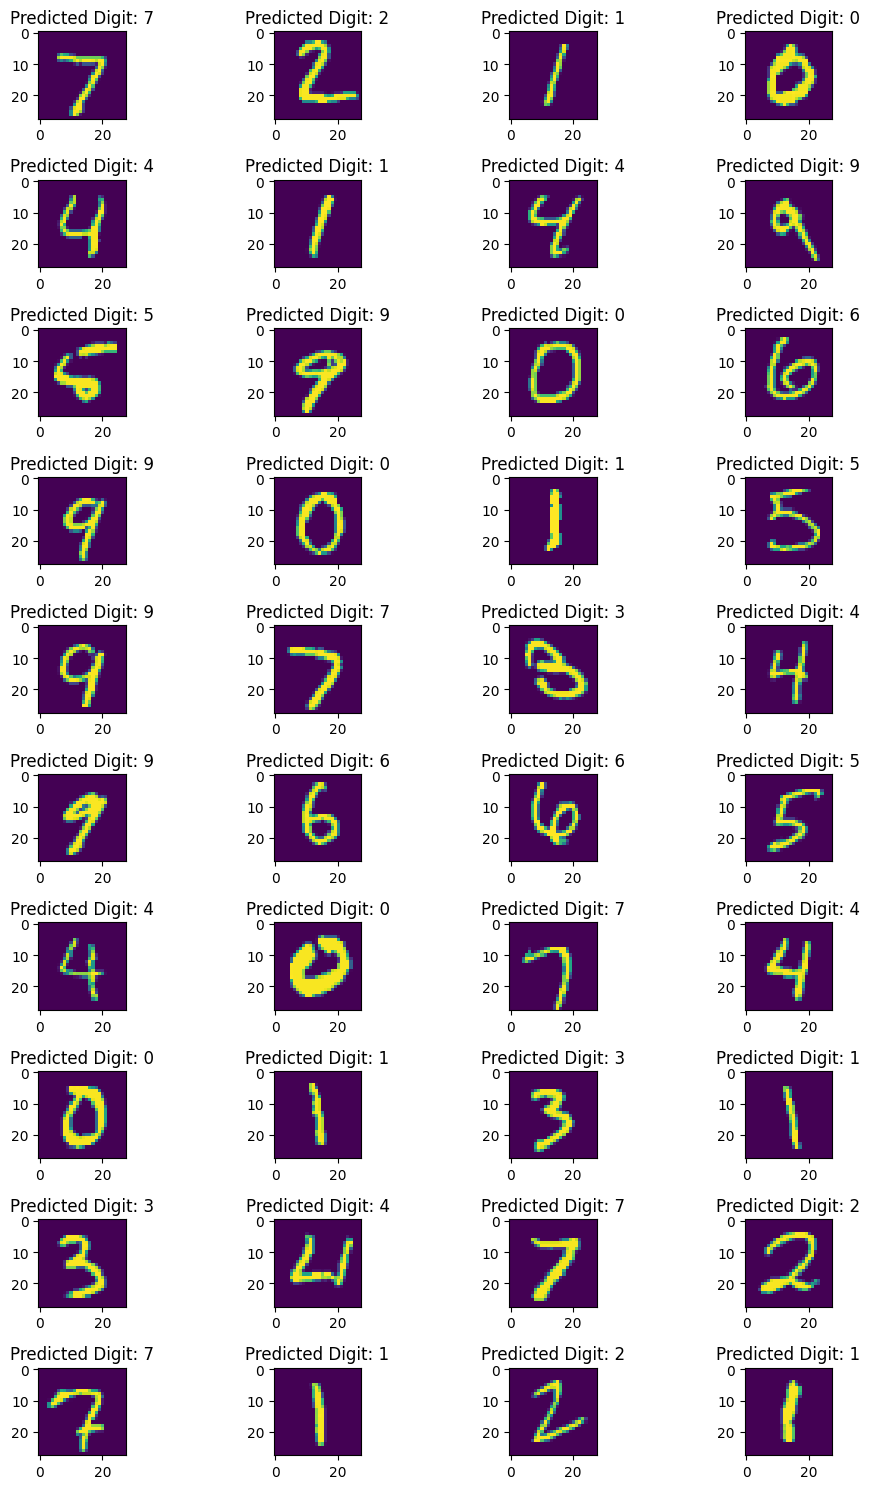

In [33]:
#plotting 40 predictions
fig, ax = plt.subplots(10,4,figsize=(10,15))
for i in range(40):
    plt.subplot(10,4,i+1)
    plt.imshow(xs[i])
    plt.title(f'Predicted Digit: {yhats[i]}')
fig.tight_layout()
plt.show()